In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph
from pyclustering.cluster.xmeans import xmeans

In [2]:
df = pd.read_csv('dataset/preprocessed_dataset.csv')
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,length_ms,frame_count,intensity,zero_crossings_sum,...,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,mean,std,kur,skew
0,1,3,0,0,1,0,3737,179379.0,0.098427,1.121235,...,0.674807,-0.276204,-0.734044,0.175085,0.0,-1.215025,3.844916e-07,0.014482,9.406061,0.706488
1,1,0,0,0,0,0,3904,187387.0,NaN,0.278471,...,0.264372,-0.365037,-0.706940,0.883757,0.0,-1.384174,-7.149491e-08,0.020417,19.564187,0.748262
2,0,4,1,0,1,0,4671,224224.0,0.631165,1.592681,...,0.665423,0.250018,-1.163996,0.879099,0.0,-1.242947,2.429985e-06,0.024317,4.881241,0.771346
3,1,7,0,1,0,0,3637,174575.0,-1.348146,-0.346031,...,0.297811,-0.707183,-0.830636,1.227493,0.0,-1.445318,2.373929e-07,0.003561,13.040259,-0.072032
4,0,4,1,0,1,0,4404,211411.0,0.758500,0.614322,...,0.628032,0.418192,-0.725278,0.811169,0.0,-1.366742,8.454691e-07,0.027522,7.485109,1.018009


In [3]:
df_dict = {'sex': df,'emotion': df}

In [4]:
df_plot = pd.read_csv('dataset/preprocessed_dataset.csv')
df_plot.shape

(2421, 27)

In [5]:
for key in df_dict:
    if key == 'emotion':
        to_drop = df_dict[key].columns.difference(['mfcc_std', 'sc_kur', 'stft_kur', 'mean', 'std', 'kur'])
        df_dict[key] = df_dict[key].drop(to_drop, axis=1)
    elif key == 'sex':
        to_drop = df_dict[key].columns.difference(['mfcc_max', 'stft_std', 'stft_mean', 'mfcc_mean'])
        df_dict[key] = df_dict[key].drop(to_drop, axis=1)

df_dict['sex'].head()

,mfcc_mean,mfcc_max,stft_mean,stft_std
0,-1.057124,-1.057283,-0.734044,0.175085
1,-0.164264,0.224027,-0.706940,0.883757
2,-0.395188,-1.297048,-1.163996,0.879099
3,-1.633922,-0.351757,-0.830636,1.227493
4,-0.590964,-1.463286,-0.725278,0.811169


In [6]:
scaler = MinMaxScaler()
X_minmax_dict = {}

for key in df_dict:
    scaler.fit(df_dict[key])
    X_minmax_dict[key] = scaler.transform(df_dict[key])

X_minmax_dict['sex'].shape, X_minmax_dict['emotion'].shape

((2421, 4), (2421, 6))

# K-means

In [7]:
sse_list = []
silhouette_list = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax_dict['emotion'])
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X_minmax_dict['emotion'], kmeans.labels_))

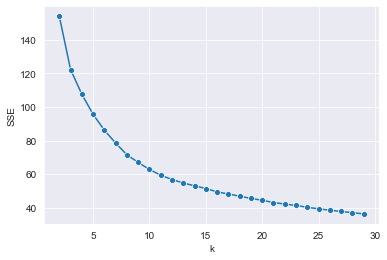

In [8]:
sns.lineplot(x=range(2, len(sse_list) + 2), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

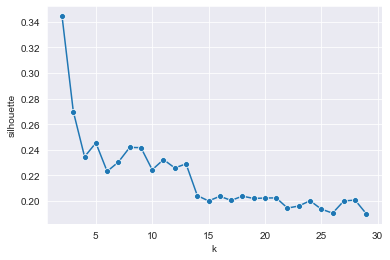

In [9]:
sns.lineplot(x=range(2, len(silhouette_list) + 2), y=silhouette_list, marker='o')
plt.ylabel('silhouette')
plt.xlabel('k')
plt.show()

In [10]:
kmeans = KMeans(n_clusters=8, n_init=10, max_iter=100)
kmeans.fit(X_minmax_dict['emotion'])

KMeans(max_iter=100)

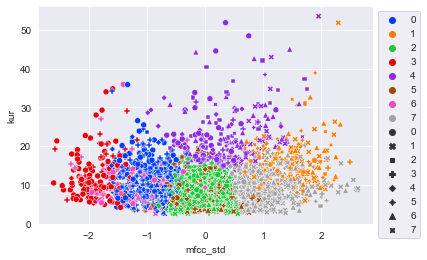

In [11]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=kmeans.labels_, style='emotion',
                palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [12]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax_dict['emotion'], kmeans.labels_))

SSE 71.52146389950386
Silhouette 0.24178543761420995


## K-mean sex analisys

In [13]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans.fit(X_minmax_dict['sex'])

KMeans(max_iter=100, n_clusters=2)

In [14]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax_dict['emotion'], kmeans.labels_))

SSE 163.5177292370423
Silhouette 0.02090425320573464


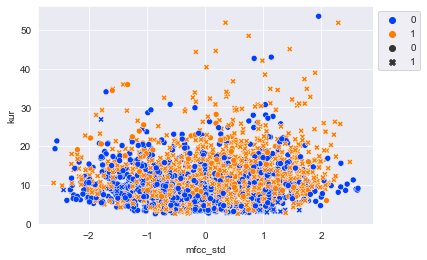

In [15]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=kmeans.labels_, style='sex',
                palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [16]:
df_plot['kmean'] = kmeans.labels_

In [17]:
a = len(df_plot[(df_plot['kmean'] == 0) & (df_plot['sex'] == 0)])
b = len(df_plot[(df_plot['kmean'] == 1) & (df_plot['sex'] == 0)])
print(f'Mismatched F in cluster 0: {a}, F in cluster 1: {b}')

Mismatched F in cluster 0: 941, F in cluster 1: 247


In [18]:
a = len(df_plot[(df_plot['kmean'] == 0) & (df_plot['sex'] == 1)])
b = len(df_plot[(df_plot['kmean'] == 1) & (df_plot['sex'] == 1)])
print(f'M in cluster 0: {a}, mismatched M in cluster 1: {b}')

M in cluster 0: 103, mismatched M in cluster 1: 1130


# Bisecting K-means

In [19]:
bkmeans = BisectingKMeans(n_clusters=8)
bkmeans.fit(X_minmax_dict['emotion'])

BisectingKMeans()

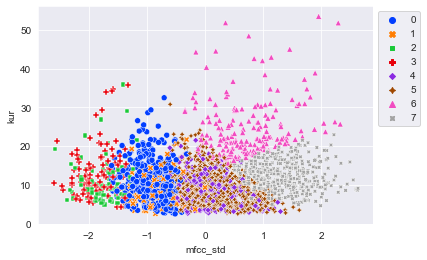

In [20]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=bkmeans.labels_, style=bkmeans.labels_,
                palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [21]:
print('SSE', bkmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax_dict['emotion'], bkmeans.labels_))

SSE 80.333152068775
Silhouette 0.2078320589194215


## Bisecting kmeans sex analisys

In [22]:
bkmeans = BisectingKMeans(n_clusters=2)
bkmeans.fit(X_minmax_dict['sex'])

BisectingKMeans(n_clusters=2)

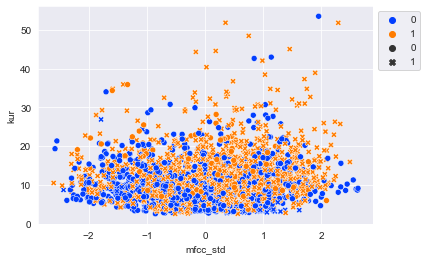

In [23]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=bkmeans.labels_, style='sex',
                palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [24]:
print('SSE', bkmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax_dict['sex'], bkmeans.labels_))

SSE 163.55411757154144
Silhouette 0.3353156894775127


In [25]:
df_plot['b-kmean'] = bkmeans.labels_

In [26]:
a = len(df_plot[(df_plot['b-kmean'] == 0) & (df_plot['sex'] == 0)])
b = len(df_plot[(df_plot['b-kmean'] == 1) & (df_plot['sex'] == 0)])
print(f'F in cluster 0: {a}, mismatched F in cluster 1: {b}')

F in cluster 0: 946, mismatched F in cluster 1: 242


In [27]:
a = len(df_plot[(df_plot['b-kmean'] == 0) & (df_plot['sex'] == 1)])
b = len(df_plot[(df_plot['b-kmean'] == 1) & (df_plot['sex'] == 1)])
print(f'Mismatched M in cluster 0: {a}, M in cluster 1: {b}')

Mismatched M in cluster 0: 105, M in cluster 1: 1128


# DBSCAN

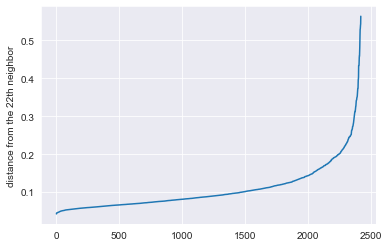

In [28]:
dist = pdist(X_minmax_dict['emotion'], 'euclidean')
dist = squareform(dist)

k = 22
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'distance from the {k}th neighbor')
plt.show()

In [29]:
dbscan = DBSCAN(eps=0.095, min_samples=22, metric='euclidean') # 0.095, 22
dbscan.fit(X_minmax_dict['emotion'])

DBSCAN(eps=0.095, min_samples=22)

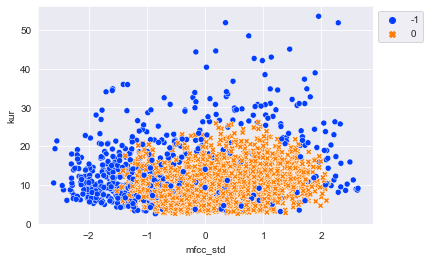

In [30]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=dbscan.labels_,
                style=dbscan.labels_, palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [31]:
hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_))))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax_dict['emotion'], dbscan.labels_))

labels {-1: 606, 0: 1815}
silhouette 0.3283051619635856


# DBSCAN sex analisys

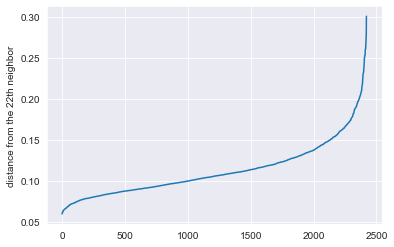

In [33]:
dist = pdist(X_minmax_dict['sex'], 'euclidean')
dist = squareform(dist)

k = 22
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'distance from the {k}th neighbor')
plt.show()

In [34]:
dbscan = DBSCAN(eps=0.095, min_samples=22, metric='euclidean')
dbscan.fit(X_minmax_dict['sex'])

DBSCAN(eps=0.095, min_samples=22)

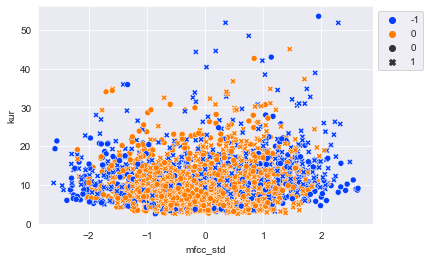

In [35]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=dbscan.labels_,
                style='sex', palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [36]:
hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_))))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax_dict['emotion'], dbscan.labels_))

labels {-1: 754, 0: 1667}
silhouette 0.14500965669690905


# Hierarchical

In [40]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [41]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(df_dict['emotion'])

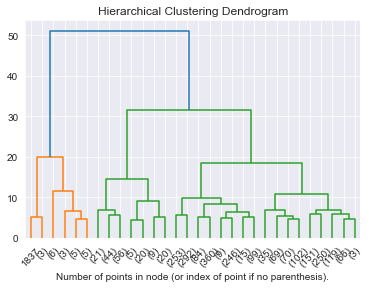

In [42]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.show()

In [43]:
hier = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='complete')
hier.fit(df_dict['emotion'])

AgglomerativeClustering(linkage='complete', n_clusters=8)

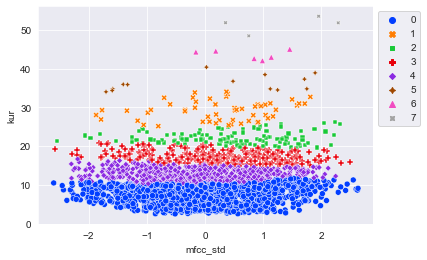

In [44]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=hier.labels_,
                style=hier.labels_, palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [45]:
hist, bins = np.histogram(hier.labels_, bins=range(0, len(set(hier.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df_dict['emotion'], hier.labels_))

labels {0: 1358, 1: 54, 2: 121, 3: 276, 4: 589, 5: 13, 6: 6, 7: 4}
silhouette 0.4282426293520812


## Hierarchical sex analisys

In [46]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(df_dict['sex'])

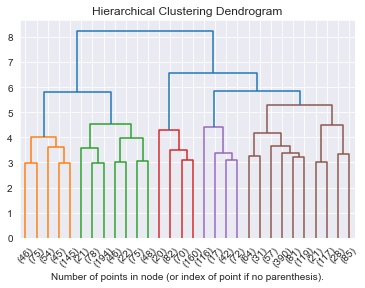

In [47]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.show()

In [48]:
hier = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
hier.fit(df_dict['sex'])

AgglomerativeClustering(linkage='complete')

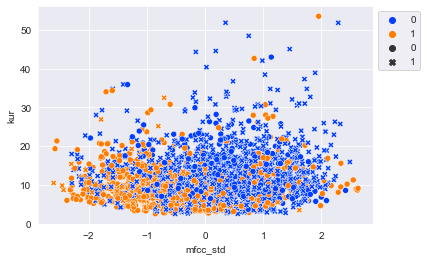

In [49]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=hier.labels_,
                style='sex', palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [50]:
hist, bins = np.histogram(hier.labels_, bins=range(0, len(set(hier.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df_dict['sex'], hier.labels_))

labels {0: 1572, 1: 849}
silhouette 0.28376697740825857


In [51]:
df_plot['hier'] = hier.labels_

In [52]:
a = len(df_plot[(df_plot['hier'] == 0) & (df_plot['sex'] == 0)])
b = len(df_plot[(df_plot['hier'] == 1) & (df_plot['sex'] == 0)])
print(f'Mismatched F in cluster 0: {a}, F in cluster 1: {b}')

Mismatched F in cluster 0: 449, F in cluster 1: 739


In [53]:
a = len(df_plot[(df_plot['hier'] == 0) & (df_plot['sex'] == 1)])
b = len(df_plot[(df_plot['hier'] == 1) & (df_plot['sex'] == 1)])
print(f'M in cluster 0: {a}, mismatched M in cluster 1: {b}')

M in cluster 0: 1123, mismatched M in cluster 1: 110


### Ward's method

In [54]:
connectivity = kneighbors_graph(df_dict['sex'], n_neighbors=100, include_self=False)

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward', affinity='euclidean',
                                   connectivity=connectivity)
model=model.fit(df_dict['sex'])
ward = AgglomerativeClustering(n_clusters=2 ,linkage='ward', affinity='euclidean',
                                   connectivity=connectivity)
ward.fit(df_dict['sex'])

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df_dict['sex'], ward.labels_))

labels {0: 1490, 1: 931}
silhouette 0.2820604530172724


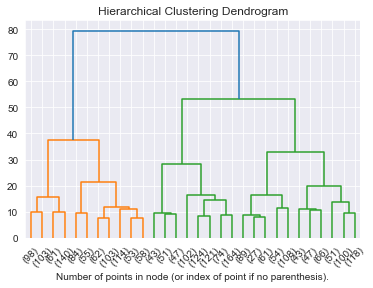

In [55]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.show()

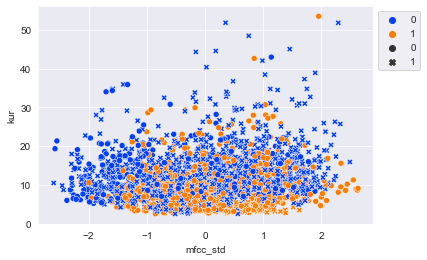

In [56]:
sns.scatterplot(data=df_plot, x='mfcc_std', y='kur', hue=ward.labels_,
                style='sex', palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [57]:
df_plot['ward'] = ward.labels_

In [58]:
a = len(df_plot[(df_plot['ward'] == 0) & (df_plot['sex'] == 0)])
b = len(df_plot[(df_plot['ward'] == 1) & (df_plot['sex'] == 0)])
print(f'Mismatched F in cluster 0: {a}, F in cluster 1: {b}')

Mismatched F in cluster 0: 395, F in cluster 1: 793


In [59]:
a = len(df_plot[(df_plot['ward'] == 0) & (df_plot['sex'] == 1)])
b = len(df_plot[(df_plot['ward'] == 1) & (df_plot['sex'] == 1)])
print(f'M in cluster 0: {a}, mismatched M in cluster 1: {b}')

M in cluster 0: 1095, mismatched M in cluster 1: 138
